In [1]:
import sys
import os
from itertools import combinations

dir_notebook = os.path.dirname(os.path.abspath("__file__"))
dir_parent = os.path.dirname(dir_notebook)
if not dir_parent in sys.path:
    sys.path.append(dir_parent)

from PyQt5.QtWidgets import QMainWindow, QWidget, QGridLayout, QVBoxLayout, QHBoxLayout, QApplication
from optic.config import *
from optic.controls import *
from optic.dialog import *
from optic.gui import *
from optic.io import *
from optic.manager import *
from optic.gui.bind_func import *

class MicrogliaTrackingGUI(QMainWindow):
    def __init__(self):
        APP_NAME = "MICROGLIA_TRACKING"
        QMainWindow.__init__(self)
        self.widget_manager, self.config_manager, self.data_manager, self.control_manager, self.layout_manager = initManagers(
            WidgetManager(), ConfigManager(), DataManager(), ControlManager(), LayoutManager()
        )
        self.config_manager.setCurrentApp(APP_NAME)
        self.app_keys = self.config_manager.gui_defaults["APP_KEYS"]

        self.setupUI_done = False
        setupMainWindow(self, self.config_manager.gui_defaults)

        self.initUI()

    """
    setup UI Function
    """
    def initUI(self):
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        self.layout_main = QGridLayout(self.central_widget)

        # file load UI
        self.layout_file_load = QHBoxLayout()
        self.setupFileLoadUI()
        self.layout_main.addLayout(self.layout_file_load, 1, 0, 1, 1)

        # main UI
        self.layout_main_ui = QGridLayout()
        self.layout_main.addLayout(self.layout_main_ui, 0, 0, 1, 2)
        # extra UI (bottom)
        self.layout_extra_ui = QHBoxLayout()
        self.layout_main.addLayout(self.layout_extra_ui, 1, 1, 1, 1)

    def setupFileLoadUI(self):
        file_load_widget = QWidget()
        layout = QVBoxLayout(file_load_widget)

        layout.addLayout(self.makeLayoutSectionBottom())
        # bindFunc
        self.bindFuncFileLoadUI()

        self.layout_file_load.addWidget(file_load_widget)

    def loadFilePathsandInitialize(self):
        self.control_manager, self.data_manager = initManagers(self.control_manager, self.data_manager)
        success = self.loadData()
        if success:
            QMessageBox.information(self, "File load", "File loaded successfully!")
            self.setupMainUI()
        else:
            QMessageBox.warning(self, "File Load Error", "Failed to load the file.")
            return

    def setupMainUI(self):
        if self.setupUI_done:
            # clear layouts
            clearLayout(self.layout_main_ui)
            clearLayout(self.layout_extra_ui)
        
        # set up main UI
        self.setupMainUILayouts()
        self.setupControls()
        self.bindFuncAllWidget()
        self.initializeDataControlForXYCT()

        self.setupUI_done = True

    def loadData(self):
        for app_key in self.app_keys:
            success = self.data_manager.loadTiffStack(
                app_key=app_key, 
                path_tiff=self.widget_manager.dict_lineedit[f"path_tiff"].text()
            )
        return success

    def setupMainUILayouts(self):
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftUpper(), 0, 0, 1, 1)
        self.layout_main_ui.addLayout(self.makeLayoutSectionRightUpper(), 0, 1, 1, 1)
        self.layout_extra_ui.addLayout(self.makeLayoutSectionBottomExtra())

    def setupControls(self):
        for app_key in self.app_keys:
            self.control_manager.table_controls[app_key] = TableControl(
                app_key=app_key,
                q_table=self.widget_manager.dict_table[app_key],
                data_manager=self.data_manager,
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
            )
            self.control_manager.table_controls[app_key].setupWidgetDynamicTable(app_key)

            self.control_manager.view_controls[app_key] = ViewControl(
                app_key=app_key,
                q_view=self.widget_manager.dict_view[app_key], 
                q_scene=self.widget_manager.dict_scene[app_key], 
                data_manager=self.data_manager, 
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
                app_key_sec=self.app_keys[1] if app_key == self.app_keys[0] else None # only "pri" app_key has sec app_key
            )
            # self.control_manager.view_controls[app_key].setViewSize()
            self.control_manager.view_controls[app_key].setShowRegImROI(False)
            self.control_manager.view_controls[app_key].setShowRegStack(False)

        # set "sec" view's slider to "1"
        self.widget_manager.dict_slider[f"{self.app_keys[1]}_plane_t"].setValue(1)
        self.control_manager.view_controls[self.app_keys[1]].setPlaneT(1)
        self.control_manager.table_controls[self.app_keys[1]].setPlaneT(1)

    # for XYCT data, control
    def initializeDataControlForXYCT(self):
        for plane_t in range(self.data_manager.getSizeOfT(self.app_keys[0])):
            self.data_manager.dict_roi_coords_xyct[plane_t] = {}
            self.data_manager.dict_roi_coords_xyct_reg[plane_t] = {}
            self.data_manager.dict_roi_matching["id"][plane_t] = []
            for app_key in self.app_keys:
                self.control_manager.view_controls[app_key].roi_colors_xyct[plane_t] = {}

        list_plane_combi = list(combinations(range(self.data_manager.getSizeOfT(self.app_keys[0])), 2))
        for plane_pri, plane_sec in list_plane_combi:
            # Initialize the nested dictionaries if not already present
            if plane_pri not in self.data_manager.dict_roi_matching["match"]:
                self.data_manager.dict_roi_matching["match"][plane_pri] = {}
            if plane_sec not in self.data_manager.dict_roi_matching["match"][plane_pri]:
                self.data_manager.dict_roi_matching["match"][plane_pri][plane_sec] = {}


    """
    makeLayout Function; Component
    小要素のLayout
    return -> Layout
    """

    "Bottom"
    def makeLayoutComponentFileLoadUI(self):
        layout = QVBoxLayout()
        # Label
        layout.addWidget(self.widget_manager.makeWidgetLabel(key="load_tiff", label="File Load", font_size=12, bold=True, italic=True, use_global_style=False))
        # LineEdit
        key = "path_tiff"
        layout.addLayout(makeLayoutLoadFileWidget(self.widget_manager, label="tiff stack (XYCT) file path", key_label=key, key_lineedit=key, key_button=key))
        # Button
        layout.addLayout(makeLayoutLoadFileExitHelp(self.widget_manager))
        return layout

    "Left/Right Upper"
    # XYCT tiff stack view, slider
    def makeLayoutComponentImageView(self, app_key):
        layout = makeLayoutViewWithZTSlider(
            self.widget_manager, 
            app_key,
            slider_z=False,
            slider_t=True,
            key_label_t=f"{app_key}_plane_t",
            key_slider_t=f"{app_key}_plane_t",
            stack_size_t=self.data_manager.getSizeOfT(app_key),
            )
        return layout
    
    # channel contrast, ROI opacity slider
    def makeLayoutComponentContrastOpacitySlider(self, app_key):
        layout = QVBoxLayout()
        channels = self.config_manager.gui_defaults["CHANNELS"]
        layout_channel = QHBoxLayout()
        for channel in channels:
            layout_channel.addLayout(makeLayoutContrastSlider(
                self.widget_manager, 
                key_label=f"{app_key}_{channel}", 
                key_checkbox=f"{app_key}_{channel}", 
                key_slider=f"{app_key}_{channel}", 
                label_checkbox=f"Show {channel} channel", 
                label_label=f"{channel} Value", 
                checked=True
            ))

        layout.addLayout(layout_channel)
        layout.addLayout(makeLayoutOpacitySlider(
            self.widget_manager, 
            key_label=app_key, 
            key_slider=app_key, 
            label=app_key
        ))
        return layout

    # Table, ROI IO
    def makeLayoutComponentTable_Button(self, app_key):
        layout = QVBoxLayout()
        layout.addWidget(self.widget_manager.makeWidgetTable(app_key))
        layout.addLayout(makeLayoutROIManagerForTable(
            self.widget_manager,
            key_button_roi_add=f"{app_key}_roi_add",
            key_button_roi_remove=f"{app_key}_roi_remove",
            key_button_roi_edit=f"{app_key}_roi_edit",
        ))
        layout.addLayout(makeLayoutROIEditConfig(
            self.widget_manager,
            key_label_roi_opacity=f"{app_key}_opacity_roi_edit",
            key_label_pen_radius=f"{app_key}_pen_radius",
            key_slider_roi_opacity=f"{app_key}_opacity_roi_edit",
            key_spinbox_pen_radius=f"{app_key}_pen_radius",
        ))
        return layout
    
    # View, slider
    def makeLayoutComponent_View_Slider(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentImageView(app_key))
        layout.addLayout(self.makeLayoutComponentContrastOpacitySlider(app_key))
        return layout
    
    "Bottom Extra"
    # Image Registration
    def makeLayoutComponenImageRegistration(self):
        layout = makeLayoutMicrogliaXYCTStackRegistration(
            self.widget_manager,
            self.data_manager,
            self.app_keys[0],                 
            f"elastix_registration",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",
            f"opacity_roi_pair",
            f"elastix_method",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",          
            f"elastix_config", 
            f"elastix_run_t",   
            f"export_reg_tiff",
            f"show_roi_match",
            f"show_roi_pair",
            f"show_reg_stack",
            f"show_reg_im_roi",
            f"opacity_roi_pair",
        )
        return layout
    
    # Optimal Transport ROI Matching
    def makeLayoutComponentROIMatching(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutROIMatching(
            self.widget_manager,
            "roi_matching",
            "ot_method",
            "fgwd_alpha",
            "wd_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "fgwd_alpha",
            "wd_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "ot_method",
            "ot_run",
            "ot_clear",
        ))
        layout.addLayout(makeLayoutROIMatchingTest(
            self.widget_manager,
            "roi_matching_test",
        ))
        layout.addLayout(makeLayoutROITrackingIO(
            self.widget_manager,
            "roi_matching_save",
            "roi_matching_load",
        ))
        return layout
    
    # ROI Manager
    def makeLayoutComponentCellposeROIManager(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutCellpose(
            self.widget_manager,
            self.data_manager,
            self.app_keys[0],
            "cellpose",
            "cellpose_t_plane",
            "cellpose_channel",
            "cellpose_model",
            "cellpose_restore",
            "cellpose_diameter",
            "cellpose_t_plane",
            "cellpose_channel",
            "cellpose_model",
            "cellpose_restore",
            "cellpose_diameter",
            "cellpose_run",
        ))
        layout.addLayout(makeLayoutROIManager(
            self.widget_manager,
            "roi_manager",
            "roi_save",
            "roi_load",
            "mask_save",
            "mask_load",
        ))
        return layout

    """
    makeLayout Function; Section
    領域レベルの大Layout
    """
    # 上段, 左
    # View size : Table size = 2 : 1
    def makeLayoutSectionLeftUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Slider(self.app_keys[0]), 2)
        layout.addLayout(self.makeLayoutComponentTable_Button(self.app_keys[0]), 1)
        return layout
    
    # 上段. 右
    def makeLayoutSectionRightUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Slider(self.app_keys[1]), 2)
        layout.addLayout(self.makeLayoutComponentTable_Button(self.app_keys[1]), 1)
        return layout

    # 下段
    def makeLayoutSectionBottom(self):
        layout = self.makeLayoutComponentFileLoadUI()
        return layout
    
    # 下段, 追加
    def makeLayoutSectionBottomExtra(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponenImageRegistration())
        layout.addLayout(self.makeLayoutComponentROIMatching())
        layout.addLayout(self.makeLayoutComponentCellposeROIManager())
        return layout
    
    """
    make SubWindow, Dialog Function
    """
    def showSubWindowElastixParamsConfig(self):
        config_window = ElastixParamsConfigDialog(
            self, 
            self.config_manager.json_config.get("elastix_params"),
            self.config_manager.gui_defaults,
        )
        if config_window.exec_() == QDialog.Accepted:
            self.config_manager.json_config.set("elastix_params", config_window.elastix_params)

    """
    bindFunc Function
    配置したwidgetに関数を紐づけ
    """
    def bindFuncFileLoadUI(self):        
        bindFuncLoadFileWidget(
            q_widget=self, 
            q_button=self.widget_manager.dict_button["path_tiff"], 
            q_lineedit=self.widget_manager.dict_lineedit["path_tiff"], 
            filetype=Extension.TIFF
        )

        self.widget_manager.dict_button["load_file"].clicked.connect(lambda: self.loadFilePathsandInitialize())
        bindFuncExit(q_window=self, q_button=self.widget_manager.dict_button["exit"])
        bindFuncHelp(q_button=self.widget_manager.dict_button["help"], url=AccessURL.HELP[self.config_manager.current_app])

    def bindFuncAllWidget(self):
        for app_key in self.app_keys:
            # Slider Opacity valueChanged
            bindFuncOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_all"],
                view_control=self.control_manager.view_controls[app_key],
            )
            bindFuncHighlightOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_selected"],
                view_control=self.control_manager.view_controls[app_key],
            )
            # Slider Contrast valueChanged, Checkbox show channel stateChanged
            for channel in self.config_manager.gui_defaults["CHANNELS"]:
                bindFuncBackgroundContrastSlider(
                    q_slider_min=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_min"],
                    q_slider_max=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_max"],
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel
                )
                bindFuncBackgroundVisibilityCheckbox(
                    q_checkbox=self.widget_manager.dict_checkbox[f"{app_key}_{channel}_show"], 
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel,
                )
            # ROI Manager for Table
            bindFuncButtonsROIManagerForTable(
                q_button_add=self.widget_manager.dict_button[f"{app_key}_roi_add"],
                q_button_remove=self.widget_manager.dict_button[f"{app_key}_roi_remove"],
                q_button_edit=self.widget_manager.dict_button[f"{app_key}_roi_edit"],
                q_table=self.widget_manager.dict_table[app_key],
                data_manager=self.data_manager,
                control_manager=self.control_manager,
                table_control=self.control_manager.table_controls[app_key],
                view_control=self.control_manager.view_controls[app_key],
                app_key_pri=self.app_keys[0],
                app_key_sec=self.app_keys[1]
            )
            # ROI Edit Config
            bindFuncSliderSpinBoxROIEditConfig(
                q_slider_opacity=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_edit"],
                q_spinbox_radius=self.widget_manager.dict_spinbox[f"{app_key}_pen_radius"],
                view_control=self.control_manager.view_controls[app_key]
            )
            # View Event
            bindFuncViewEvents(
                q_view=self.widget_manager.dict_view[app_key],
                view_control=self.control_manager.view_controls[app_key],
            )

        # T slider
        bindFuncPlaneTSliderWithXYCTTracking(
            q_slider_pri=self.widget_manager.dict_slider[f"{self.app_keys[0]}_plane_t"],
            q_slider_sec=self.widget_manager.dict_slider[f"{self.app_keys[1]}_plane_t"],
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            table_control_pri=self.control_manager.table_controls[self.app_keys[0]],
            table_control_sec=self.control_manager.table_controls[self.app_keys[1]],
        )
        # ROI Table onSelectionChanged
        bindFuncTableSelectionChangedWithTracking(
            q_table_pri=self.widget_manager.dict_table[self.app_keys[0]],
            q_table_sec=self.widget_manager.dict_table[self.app_keys[1]],
            table_control_pri=self.control_manager.table_controls[self.app_keys[0]],
            table_control_sec=self.control_manager.table_controls[self.app_keys[1]],
            view_control_pri=self.control_manager.view_controls[self.app_keys[0]],
            view_control_sec=self.control_manager.view_controls[self.app_keys[1]],
            canvas_control_pri=None,
            canvas_control_sec=None,
        )
        # ROI Table onCellChanged
        bindFuncTableCellChangedWithMicrogliaTracking(
            q_table_pri=self.widget_manager.dict_table[self.app_keys[0]],
            control_manager=self.control_manager,
            data_manager=self.data_manager,
        )
        # Cellpose ROI mask IO
        bindFuncROIMaskNpyIO(
            q_button_save=self.widget_manager.dict_button["mask_save"],
            q_button_load=self.widget_manager.dict_button["mask_load"],
            q_window=self,
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            app_key=self.app_keys[0]
        )
        # Show matched ROI
        bindFuncCheckboxShowMatchedROI(
            q_checkbox=self.widget_manager.dict_checkbox['show_roi_match'],
            view_controls=self.control_manager.view_controls
        )
        # Show ROI pair
        bindFuncCheckboxShowROIPair(
            q_checkbox=self.widget_manager.dict_checkbox['show_roi_pair'],
            view_controls=self.control_manager.view_controls
        )
        # Slider ROI pair Opacity valueChanged
        bindFuncROIPairOpacitySlider(
            q_slider=self.widget_manager.dict_slider[f"opacity_roi_pair"],
            view_control=self.control_manager.view_controls[self.app_keys[0]],
        )
        # Show registered background image
        bindFuncCheckboxShowRegisteredStack(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_stack'],
            view_controls=self.control_manager.view_controls
        )
        # Show registered ROI image
        bindFuncCheckboxShowRegisteredROIImage(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_im_roi'],
            view_controls=self.control_manager.view_controls
        )
        # run Elastix registration t-axis
        bindFuncButtonRunElastixForMicrogliaXYCTStackRegistration(
                self,
                q_button=self.widget_manager.dict_button[f"elastix_run_t"],
                data_manager=self.data_manager,
                config_manager=self.config_manager,
                app_keys=self.app_keys,
                combobox_elastix_method=self.widget_manager.dict_combobox[f"elastix_method"],
                combobox_channel_ref=self.widget_manager.dict_combobox[f"elastix_ref_c"],
                combobox_idx_ref=self.widget_manager.dict_combobox[f"elastix_ref_plane_t"],
        )
        # Elastix config
        self.widget_manager.dict_button[f"elastix_config"].clicked.connect(
            lambda: self.showSubWindowElastixParamsConfig()
        )
        # Microglia Tracking IO
        bindFuncMicrogliaTrackingIO(
            self.widget_manager.dict_button["roi_matching_save"],
            self.widget_manager.dict_button["roi_matching_load"],
            self,
            self.widget_manager.dict_lineedit["path_tiff"],
            self.config_manager,
            self.data_manager,
            self.control_manager,
        )
        # ROI Matching Run
        bindFuncButtonRunROIMatchingForXYCT(
            self,
            q_button=self.widget_manager.dict_button['ot_run'],
            widget_manager=self.widget_manager,
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            app_key_pri=self.app_keys[0],
            app_key_sec=self.app_keys[1],
        )
        # Clear ROI Matching result
        bindFuncButtonClearColumnCells(
            q_button=self.widget_manager.dict_button['ot_clear'],
            q_table=self.widget_manager.dict_table[self.app_keys[0]],
            idx_col=self.config_manager.table_columns[self.app_keys[0]].getColumns()["Cell_ID_Match"]["order"], # hardcoded !!!
        )
        # run Cellpose
        bindFuncButtonRunCellposeForXYCT(
            self.data_manager,
            self.control_manager,
            self.config_manager,
            self.widget_manager.dict_button["cellpose_run"],
            self.widget_manager.dict_combobox["cellpose_t_plane"],
            self.widget_manager.dict_combobox["cellpose_channel"],
            self.widget_manager.dict_combobox["cellpose_model"],
            self.widget_manager.dict_combobox["cellpose_restore"],
            self.widget_manager.dict_spinbox["cellpose_diameter"],
        )

if __name__ == "__main__":
    app = QApplication(sys.argv) if QApplication.instance() is None else QApplication.instance()
    applyAppStyle(app)
    gui = MicrogliaTrackingGUI()
    gui.show()
    sys.exit(app.exec_())

SystemExit: 0

To exit: use 'exit', 'quit', or Ctrl-D.


In [7]:
a = (1 == 1)
a

True

In [4]:
gui.control_manager.view_controls["pri"].roi_colors_xyct

defaultdict(dict, {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}})

In [4]:
# cellpose

import tifffile
import numpy as np
from cellpose import denoise, io

imgs = gui.data_manager.dict_tiff["pri"]
imgs = imgs[:, :, :, 0, :] # XYCT
imgs = imgs.transpose(3, 2, 0, 1) # TCXY
img = imgs[0] # CXY
img = img[0] # XY

io.logger_setup()

# DEFINE CELLPOSE MODEL
# model_type="cyto3" or "nuclei", or other model
# restore_type: "denoise_cyto3", "deblur_cyto3", "upsample_cyto3", "denoise_nuclei", "deblur_nuclei", "upsample_nuclei"
model = denoise.CellposeDenoiseModel(gpu=True, model_type="cyto3",
                                     restore_type="deblur_nuclei")

diam = 10
mask, flow, style, img_dn = model.eval(img, diameter=diam, channels=[0, 0])

creating new log file
2025-01-24 13:15:16,753 [INFO] WRITING LOG OUTPUT TO C:\Users\HyperPC_Smee\.cellpose\run.log
2025-01-24 13:15:16,753 [INFO] 
cellpose version: 	3.1.0 
platform:       	win32 
python version: 	3.8.19 
torch version:  	2.3.1
2025-01-24 13:15:16,754 [INFO] >> deblur_nuclei << model set to be used
2025-01-24 13:15:16,964 [INFO] ** TORCH CUDA version installed and working. **
2025-01-24 13:15:16,964 [INFO] >>>> using GPU (CUDA)
2025-01-24 13:15:17,195 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-01-24 13:15:17,195 [INFO] >> cyto3 << model set to be used
2025-01-24 13:15:17,195 [INFO] ** TORCH CUDA version installed and working. **
2025-01-24 13:15:17,196 [INFO] >>>> using GPU (CUDA)
2025-01-24 13:15:17,228 [INFO] >>>> loading model C:\Users\HyperPC_Smee\.cellpose\models\cyto3
2025-01-24 13:15:17,266 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


In [10]:
gui.data_manager.dict_roi_matching

{'id': {0: [0, 1, 2], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []},
 'match': {0: {1: {0: None, 1: None, 2: None},
   2: {0: None, 1: None, 2: None},
   3: {0: None, 1: None, 2: None},
   4: {0: None, 1: None, 2: None},
   5: {0: None, 1: None, 2: None},
   6: {0: None, 1: None, 2: None},
   7: {0: None, 1: None, 2: None}},
  1: {2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}},
  2: {3: {}, 4: {}, 5: {}, 6: {}, 7: {}},
  3: {4: {}, 5: {}, 6: {}, 7: {}},
  4: {5: {}, 6: {}, 7: {}},
  5: {6: {}, 7: {}},
  6: {7: {}}}}

In [12]:
from __future__ import annotations

def convertSingleCellposeMaskToDictROIMatching(
    dict_roi_matching : Dict[str, Dict[int, List[int] | Dict[int, Dict[int, Optional[int]]]]],
    mask              : np.ndarray[np.uint16, Tuple[int, int]], 
    t_plane           : int,
) -> Dict[str, Dict[int, List[int] | Dict[int, Dict[int, Optional[int]]]]]:
    """
    Convert a Cellpose mask array into a dict_roi_matching structure.
    Dict["id", Dict[plane_t, List[roi_id]]], "match", Dict[plane_t_pri, Dict[plane_t_sec, Dict[roi_id, Optional[roi_id]]]]
    """
    # ROI id
    dict_roi_matching["id"][t_plane] = list(np.arange(len(np.delete(np.unique(mask), 0)))) # cellpose mask's 0 is background

    # ROI match
    for t_plane_sec in dict_roi_matching["match"][t_plane].keys():
        dict_roi_matching["match"][t_plane][t_plane_sec] = {roi_id: None for roi_id in dict_roi_matching["id"][t_plane]}
    return dict_roi_matching

In [15]:
convertSingleCellposeMaskToDictROIMatching(gui.data_manager.dict_roi_matching, mask, 0)["match"]

{0: {1: {0: None,
   1: None,
   2: None,
   3: None,
   4: None,
   5: None,
   6: None,
   7: None,
   8: None,
   9: None,
   10: None,
   11: None,
   12: None,
   13: None,
   14: None,
   15: None,
   16: None,
   17: None,
   18: None,
   19: None,
   20: None,
   21: None,
   22: None,
   23: None,
   24: None,
   25: None,
   26: None,
   27: None,
   28: None,
   29: None,
   30: None,
   31: None,
   32: None,
   33: None,
   34: None,
   35: None,
   36: None,
   37: None,
   38: None,
   39: None,
   40: None,
   41: None,
   42: None,
   43: None,
   44: None,
   45: None,
   46: None,
   47: None,
   48: None,
   49: None,
   50: None,
   51: None,
   52: None,
   53: None,
   54: None,
   55: None,
   56: None},
  2: {0: None,
   1: None,
   2: None,
   3: None,
   4: None,
   5: None,
   6: None,
   7: None,
   8: None,
   9: None,
   10: None,
   11: None,
   12: None,
   13: None,
   14: None,
   15: None,
   16: None,
   17: None,
   18: None,
   19: None,
   20: No

In [5]:
# convert Cellpose's mask into dict of ROI matching
def convertCellposeMasksToDictROIMatching(
    masks       : np.ndarray[np.uint16, Tuple[int, int, int]], 
) -> Dict[str, Dict[int, List[int] | Dict[int, Dict[int, Optional[int]]]]]:
    """
    Convert Cellpose masks array into a dict_roi_matching structure.
    Dict["id", Dict[plane_t, List[roi_id]]], "match", Dict[plane_t_pri, Dict[plane_t_sec, Dict[roi_id, Optional[roi_id]]]]
    """
    dict_roi_matching = {"id": {}, "match": {}}
    list_plane_combi = list(combinations(range(len(masks)), 2))

    # ROI ID
    for plane_t, mask in enumerate(masks):
        dict_roi_matching["id"][plane_t] = list(np.arange(len(np.delete(np.unique(mask), 0))))

    # ROI Matching
    for plane_pri, plane_sec in list_plane_combi:
        # Initialize the nested dictionaries if not already present
        if plane_pri not in dict_roi_matching["match"]:
            dict_roi_matching["match"][plane_pri] = {}
        if plane_sec not in dict_roi_matching["match"][plane_pri]:
            dict_roi_matching["match"][plane_pri][plane_sec] = {}

        # Extract the masks for the primary and secondary planes
        mask_pri, mask_sec = masks[plane_pri], masks[plane_sec]

        # Get unique ROI IDs, excluding 0 (background)
        list_roi_id_cellpose_pri = np.delete(np.unique(mask_pri), 0)
        list_roi_id_cellpose_sec = np.delete(np.unique(mask_sec), 0)

        # Perform ROI matching
        for roi_id_pri, roi_id_cellpose_pri in enumerate(list_roi_id_cellpose_pri):
            matched = False
            for roi_id_sec, roi_id_cellpose_sec in enumerate(list_roi_id_cellpose_sec):
                if roi_id_cellpose_sec == roi_id_cellpose_pri:
                    dict_roi_matching["match"][plane_pri][plane_sec][roi_id_pri] = roi_id_sec
                    matched = True
                    break
            if not matched:
                dict_roi_matching["match"][plane_pri][plane_sec][roi_id_pri] = None

    return dict_roi_matching

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [9]:
from optic.preprocessing.preprocessing_cellpose import convertCellposeMaskToDictROICoords

convertCellposeMaskToDictROICoords(mask)

{0: {'xpix': array([118, 119, 120, 121, 114, 115, 116, 117, 118, 119, 120, 121, 122,
         123, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 113,
         114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 112, 113,
         114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
         125, 126, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
         121, 122, 123, 124, 125, 126, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
         125, 126, 127, 128, 110, 111, 112, 113, 114, 115, 116, 117, 118,
         119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
         125, 126, 127, 128, 129, 130, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119, 120

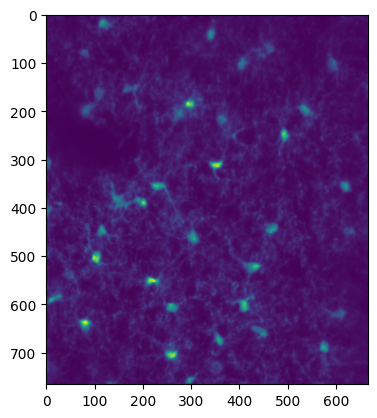

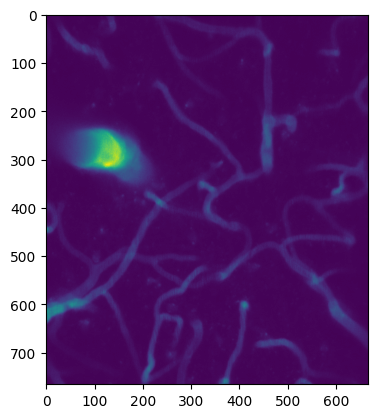

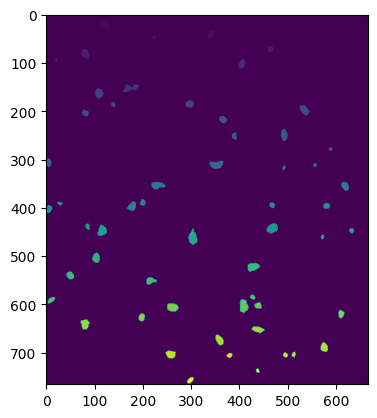

(<matplotlib.image.AxesImage at 0x221facab670>, None)

In [52]:
import matplotlib.pyplot as plt

plt.imshow(imgs[0, 0]), plt.show()
plt.imshow(imgs[0, 1]), plt.show()
plt.imshow(masks), plt.show()

In [8]:
gui.data_manager.dict_roi_coords_xyct

{0: {0: {'xpix': array([373, 406, 387, 387, 398, 379, 390, 371, 399, 399, 380, 391, 402,
          372, 383, 376, 394, 406, 387, 398, 379, 390, 371, 390, 399, 380,
          391, 402, 372, 402, 383, 405, 397, 394, 375, 386, 378, 406, 387,
          387, 398, 379, 390, 371, 401, 372, 383, 382, 405, 397, 394, 375,
          386, 378, 378, 387, 398, 379, 390, 371, 401, 393, 404, 382, 405,
          405, 374, 385, 397, 394, 375, 394, 375, 386, 378, 371, 401,   0,
          393, 404, 382, 405, 374, 385, 397, 394, 375, 386, 378, 378, 408,
          389, 400, 401, 370, 381, 381, 393, 404, 382, 374, 374, 385, 397,
          396, 375, 378, 377, 389, 400, 401,   0, 370, 381, 393, 404, 382,
          374, 385, 385, 396, 407, 377, 389, 400, 400, 401, 370,   0, 381,
          393, 404, 403, 385, 396, 396, 407, 388, 377, 389, 400, 369,   0,
          370, 381, 392, 403, 384, 395, 373, 396, 407, 388, 388, 377, 389,
          400, 392, 403, 403, 384, 395, 376, 373, 373, 396, 407, 388, 377,
          3

In [17]:
import pandas as pd
import numpy as np

df = pd.read_csv("D:/optic_figure/intermediate/fig4/DC21/master_tracking_onlyAuto.csv")
df.columns = np.arange(4)

len(df[(df[0] > -1) & (df[1] > -1)])

37

In [10]:
table_control = gui.control_manager.table_controls["pri"]

In [17]:
dict_row_cellid

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 29,
 27: 30,
 28: 31,
 29: 32,
 30: 33,
 31: 34,
 32: 35,
 33: 36,
 34: 37,
 35: 38,
 36: 39,
 37: 40,
 38: 41,
 39: 42}

In [18]:
col_id = table_control.table_columns.getColumns()['Cell_ID']['order'] # hardcoded !!!

dict_row_cellid = {row: int(table_control.q_table.item(row, col_id).text()) for row in range(table_control.len_row)}
dict_cellid_row = {v: k for k, v in dict_row_cellid.items()}

dict_cellid_row

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 29: 26,
 30: 27,
 31: 28,
 32: 29,
 33: 30,
 34: 31,
 35: 32,
 36: 33,
 37: 34,
 38: 35,
 39: 36,
 40: 37,
 41: 38,
 42: 39}